In [46]:
import joblib
import seaborn as sb
import minisom
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from collections import Counter
import pickle
from matplotlib import cm, colors
import laytr
import matplotlib.pyplot as plt
import pyranges

In [47]:
som = joblib.load("../../benchmark/GIABTR_benchmark.6.26/adotto_TRv1.1_4mers.som")

In [48]:
m_map = joblib.load("../../benchmark/GIABTR_benchmark.6.26/adotto_TRv1.1_4mers.map")


# Gotta recalculate the neurons' GC
import re
import pysam
NUCFILT = re.compile("[^ATCG]")
ref_fn = "/Users/english/code/references/grch38/GRCh38_1kg_mainchrs.fa"
ref = pysam.FastaFile(ref_fn)

def get_features(region):
    chrom, start, end = region
    seq = NUCFILT.sub("", ref.fetch(chrom, start, end))
    gcpct = (seq.count('G') + seq.count('C')) / len(seq)
    return gcpct

m_gc = []
for region in m_map['index']:
    m_gc.append(get_features(region))

m_gc = {'features':m_gc}

In [49]:
counts = np.zeros(som.distance_map().shape)
gc_pct = np.zeros(som.distance_map().shape)
for i, g in zip(m_map['map'], m_gc['features']):
    counts[i[0], i[1]] += 1
    gc_pct[i[0], i[1]] += g
gc_pct /= counts

In [50]:
all_regions = pd.read_csv("/Users/english/code/adotto/regions/adotto_TRregions_v1.2.bed", sep='\t')
#all_regions.columns = ["chr", "start", "end", "ovl_flag", "up_buff", "dn_buff", "hom_span", "n_filtered", "n_annos", "n_subregions", "mu_purity", "pct_annotated", "interspersed", "patho", "codis", "gene_flag", "biotype", "annos"]
all_regions['Neuron_x'] = m_map['map'][:, 0]
all_regions['Neuron_y'] = m_map['map'][:, 1]

In [55]:
all_pathos = pd.read_csv("/Users/english/code/adotto/pathogenic/Patho.tsv", sep='\t')

In [57]:
vntrs_meta = all_pathos[all_pathos['Repeat type'] == 'VNTR']
pathos_meta = all_pathos[all_pathos['Repeat type'] != 'VNTR']

In [72]:
len(codis)

113

In [59]:
patho = all_regions[all_regions['patho'].isin(pathos_meta['Locus'])].copy()
patho['marker'] = 'patho'

#codis = all_regions[all_regions['codis'] != '.'].copy()
#codis['marker'] = 'codis'

codis = all_regions[all_regions['patho'].isin(vntrs_meta['Locus'])].copy()
codis['marker'] = 'codis'

inter = all_regions[all_regions['interspersed'] == 'SINE'].sample(100).copy()
inter['marker'] = 'inter'

In [68]:
combined = pd.concat([inter, codis, patho], axis=0)#.sort_values('marker', ascending=False)

In [69]:
mks = combined['marker'].map({'patho':"Pathogenic", "inter": "SINE", "codis":"Phenotypic"}).values

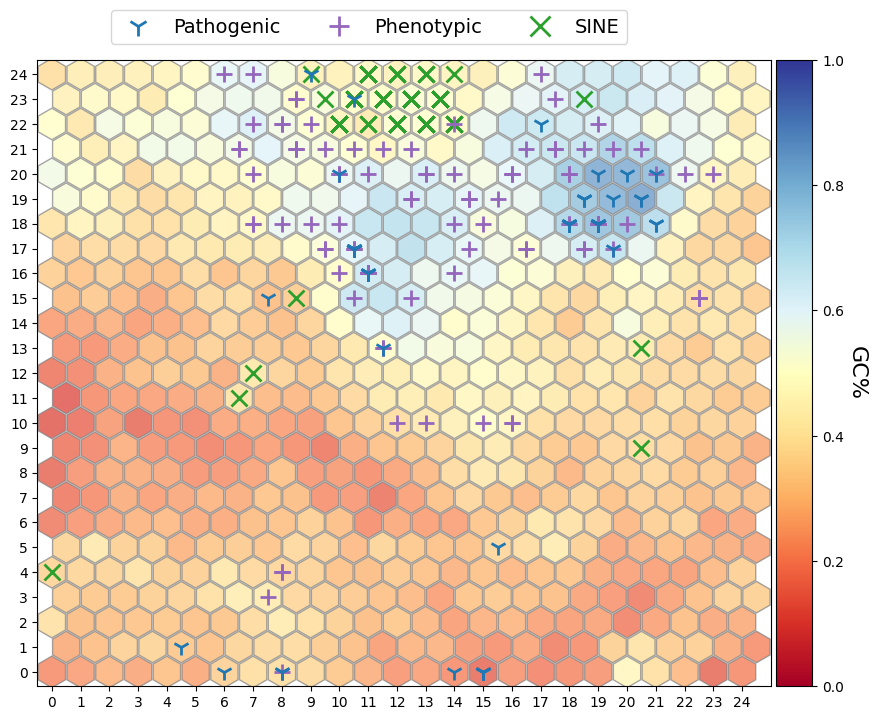

In [71]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
p = laytr.make_hex_plot(som,
                       hue=gc_pct,
                        hue_label="GC%",
                       color_map=cm.RdYlBu, alpha=0.70)
laytr.add_places(som, p, combined[["Neuron_x", "Neuron_y"]].values, mks,
                marker_map={'Pathogenic':'1', 'Phenotypic':'+', 'SINE':'x'},
                default_colors=['C0', 'C4', 'C2'])
#combined['Neuron'] = comb_winners
plt.savefig("MainSom.pdf")

In [25]:
boxA = [[18, 21], [17, 21]]
boxB = [[10, 11], [16, 17]]
boxC = [[14, 15], [0, 0]]
boxD = [[4, 6], [0, 1]]
boxE = [[10, 10], [20, 20]]
boxF = [[9, 11], [23, 24]]
boxG = [[17, 17], [22, 22]]
boxH = [[15, 15], [5, 5]]
boxI = [[7, 7], [15, 15]]
boxJ = [[8, 8], [0, 0]]

for b in [boxA, boxB, boxC, boxD, boxE, boxF, boxG, boxH, boxI, boxJ]:
    subset = combined[combined["Neuron_x"].between(b[0][0], b[0][1]) & combined["Neuron_y"].between(b[1][0], b[1][1])]['patho']
    print(b)
    print(all_pathos[all_pathos['Locus'].isin(subset)][["Motifs 1", "Motifs 2"]])
    print()

[[18, 21], [17, 21]]
   Motifs 1              Motifs 2
0       CCG                   GCC
1       NaN                   GCC
10      CAG               GCA,GCC
13      NaN                   GCG
14   GGGGCC                GGCCCC
16      CCG                   CGG
19      NaN          CGCGGGGCGGGG
21      CGG                   GGC
24      CGG                   CGG
26      NaN                   CCG
28      GGC                   CCG
33      GCN                   GCN
34      CAG               CAG,CCG
36      CGG                   CCG
38   GGCCTG         GGCCTG,CGCCTG
39      GGC                   GGC
40      NaN                   GGC
41      CGG                   CGG
42      GCG                   GCG
43      GCN                   GCN
45      GCC                   NaN
50      GCN                   NGC
53      GCN                   NaN
55      NaN                   GCC
59      GCN                   GCN
60      GCC                   NaN
61      NaN                   CGG
64      NaN  CCTCGCTGTGCCGC

# Figure 1 B - Intersection to Reference Annotations
- SegDups
- Microsatellites
- Centromeres (only 93)
- HomPct
- Promoters
- Genes

In [30]:
bdir = "/Users/english/code/adotto/manuscript/f1_som/anno_tracks/"


In [31]:
loci = pyranges.PyRanges(all_regions.rename(columns={"chr":"Chromosome",
                                             "start":"Start",
                                             "end":"End"}))
tot_cnts = np.zeros((25, 25))
for _, (x, y) in all_regions[["Neuron_x", "Neuron_y"]].iterrows():
    tot_cnts[x, y] += 1

In [32]:
np.median(tot_cnts.ravel()), 2464 / tot_cnts.sum()

(2464.0, 0.0013805437459799507)

In [33]:
tot_cnts.ravel().mean(), tot_cnts.ravel().std() , tot_cnts.ravel().min()

(2855.6864, 1882.8848651086025, 333.0)

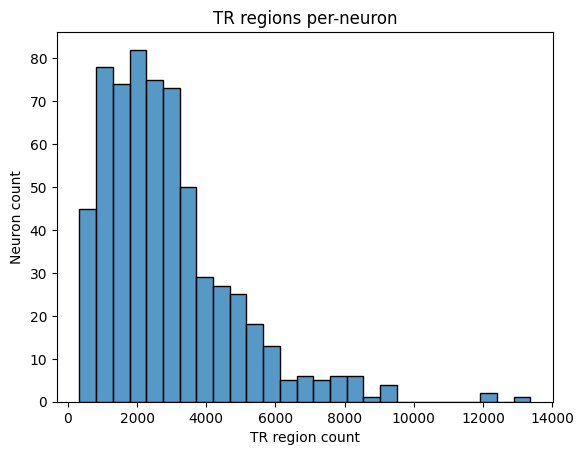

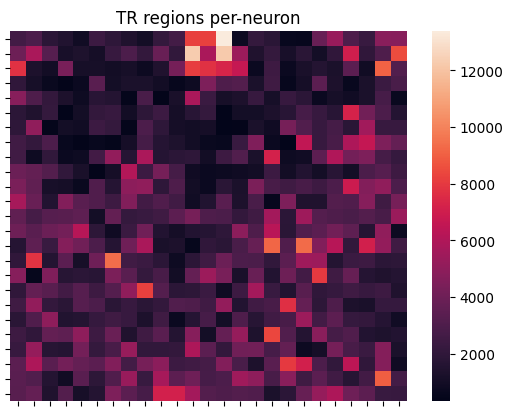

In [34]:
p = sb.histplot(data=tot_cnts.ravel())
p.set(title="TR regions per-neuron", xlabel="TR region count", ylabel="Neuron count")
plt.savefig("Sup_regperneu_hist.png")
plt.show()
p = sb.heatmap(np.flip(tot_cnts.T))
p.set(title="TR regions per-neuron", xticklabels=[], yticklabels=[])
plt.savefig("Sup_regperneu_heat.png")

In [35]:
# mu.. mu + (2 * sd)..

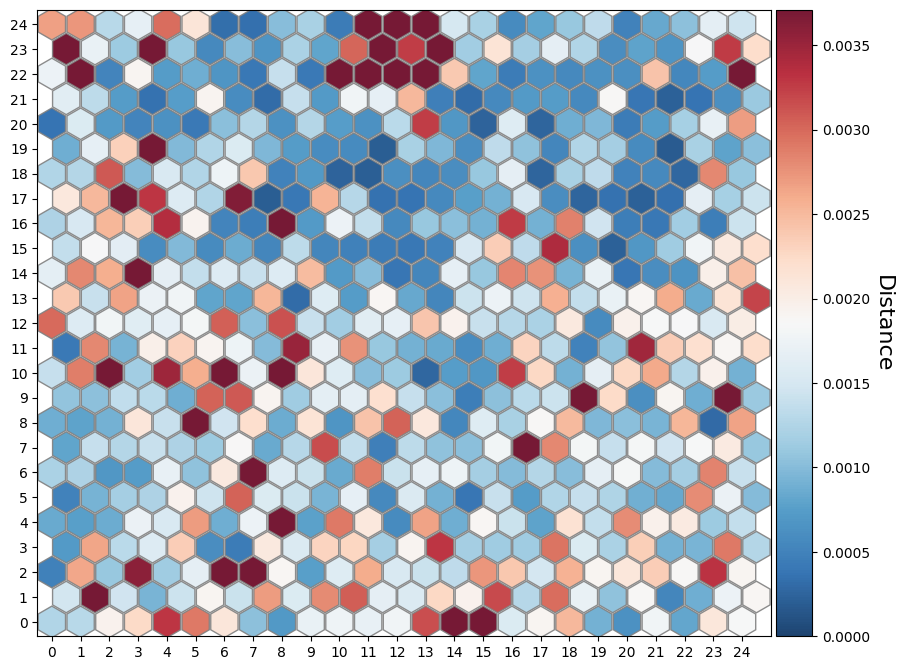

In [38]:
norm_cnts = tot_cnts / tot_cnts.sum()
mu = norm_cnts.mean()
sd = norm_cnts.std()
norm = colors.Normalize(vmin=0, vmax=mu + (2 * sd))
p = laytr.make_hex_plot(som,
                       hue=norm_cnts,
                       color_map=cm.RdBu_r,
                       color_norm=norm,
                       alpha=0.9)
plt.savefig("RegionPerNeuron.pdf")

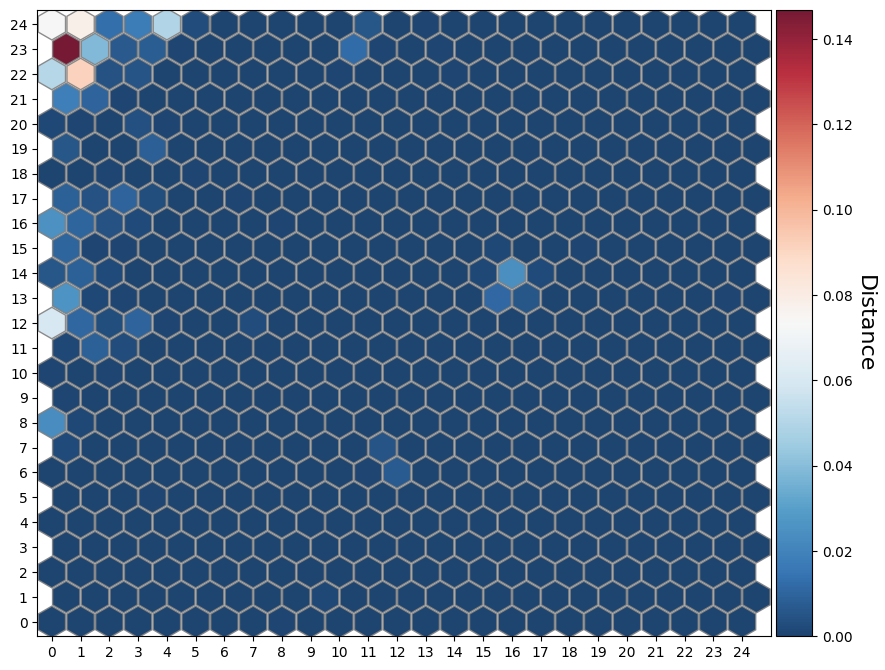

In [39]:
anno = pd.read_csv(bdir + "grch38.microsatellite.bed", sep='\t', header=None)[[0, 1, 2]].rename(columns={0:"Chromosome",
                                                                                               1:"Start",
                                                                                               2:"End"})
anno = pyranges.PyRanges(anno)

subset = loci.overlap(anno)

p_cnts = np.zeros((25, 25))
for _, (x, y) in subset.df[["Neuron_x", "Neuron_y"]].iterrows():
    p_cnts[x, y] += 1
np_cnts = p_cnts / len(subset)

norm = colors.Normalize(vmin=np_cnts.min(), vmax=np_cnts.max())
p = laytr.make_hex_plot(som,
                       hue=np_cnts,
                       color_map=cm.RdBu_r,
                       color_norm=norm,
                       alpha=0.9)
plt.savefig("Microsatellite.pdf")

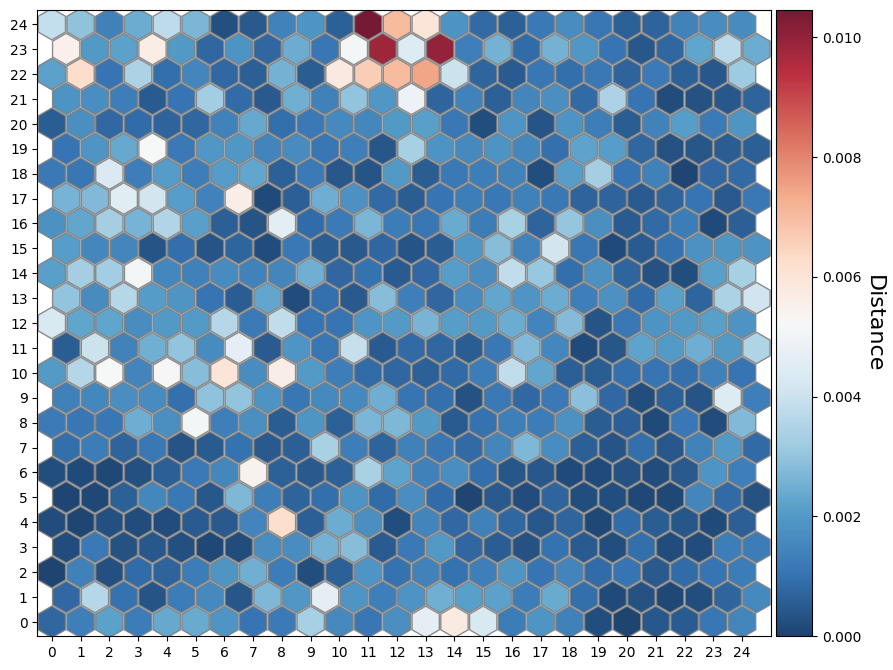

In [40]:
anno = pd.read_csv(bdir + "grch38.segdups.bed", sep='\t', header=None)[[0, 1, 2]].rename(columns={0:"Chromosome",
                                                                                               1:"Start",
                                                                                               2:"End"})
anno = pyranges.PyRanges(anno)
subset = loci.overlap(anno)

s_cnts = np.zeros((25, 25))
for _, (x, y) in subset.df[["Neuron_x", "Neuron_y"]].iterrows():
    s_cnts[x, y] += 1
ns_cnts = s_cnts / len(subset.df)

norm = colors.Normalize(vmin=ns_cnts.min(), vmax=ns_cnts.max())
p = laytr.make_hex_plot(som,
                       hue=ns_cnts,
                       color_map=cm.RdBu_r,
                       color_norm=norm,
                       alpha=0.9)
plt.savefig("SegDups.pdf")

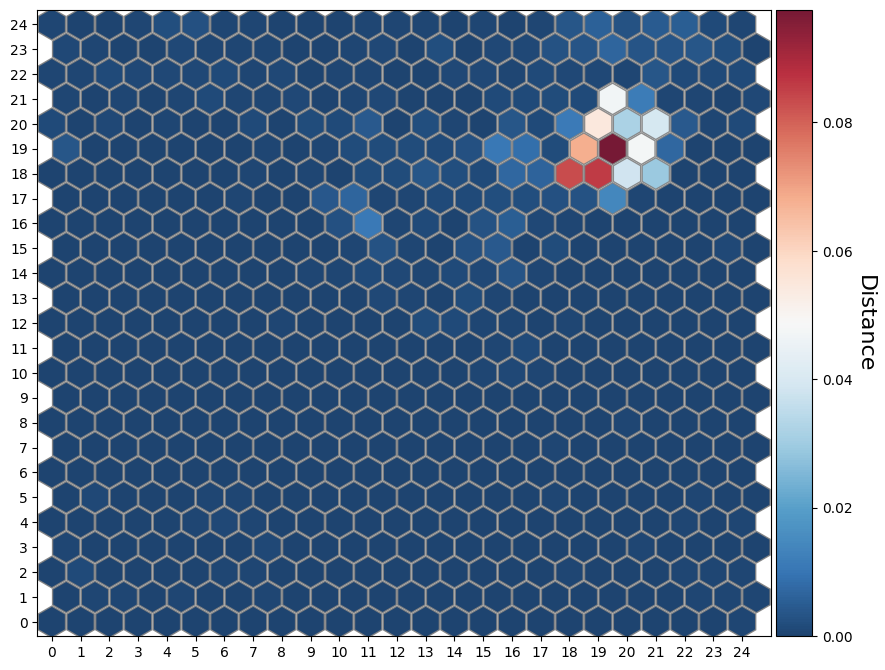

In [42]:
anno = pd.read_csv(bdir + "grch38.epdpromoters.bed", sep='\t', header=None)[[0, 1, 2]].rename(columns={0:"Chromosome",
                                                                                               1:"Start",
                                                                                               2:"End"})
anno = pyranges.PyRanges(anno)
subset = loci.overlap(anno)

s_cnts = np.zeros((25, 25))
for _, (x, y) in subset.df[["Neuron_x", "Neuron_y"]].iterrows():
    s_cnts[x, y] += 1
ns_cnts = s_cnts / len(subset)

norm = colors.Normalize(vmin=ns_cnts.min(), vmax=ns_cnts.max())
p = laytr.make_hex_plot(som,
                       hue=ns_cnts,
                       color_map=cm.RdBu_r,
                       color_norm=norm,
                       alpha=0.9)
plt.savefig("Promoters.pdf")

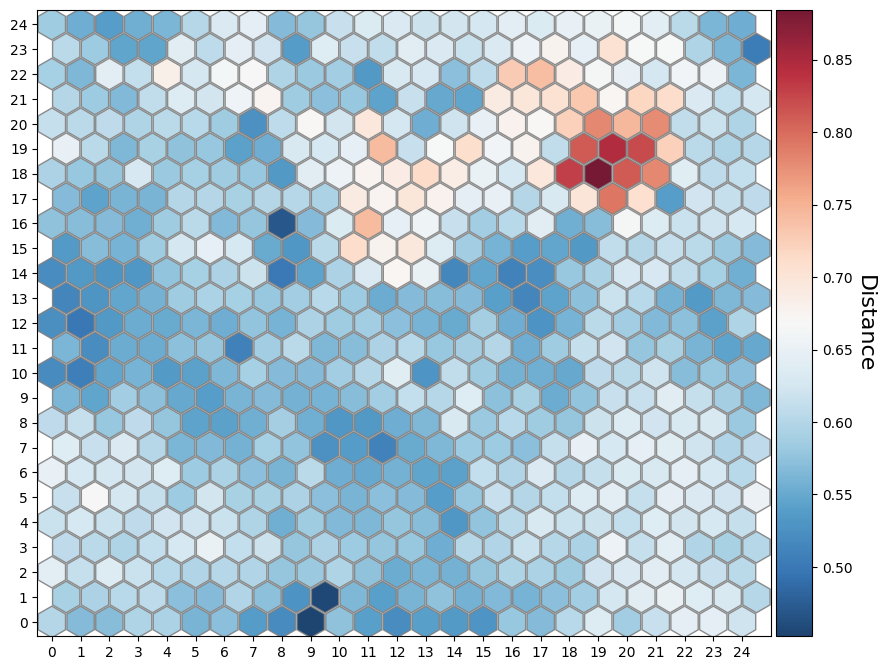

In [43]:
anno = pd.read_csv(bdir + "grch38.gencodebasicV43.bed", sep='\t', header=None)[[0, 1, 2]].rename(columns={0:"Chromosome",
                                                                                               1:"Start",
                                                                                               2:"End"})
anno = pyranges.PyRanges(anno)
subset = loci.overlap(anno)

s_cnts = np.zeros((25, 25))
for _, (x, y) in subset.df[["Neuron_x", "Neuron_y"]].iterrows():
    s_cnts[x, y] += 1
ns_cnts = s_cnts / tot_cnts

norm = colors.Normalize(vmin=ns_cnts.min(), vmax=ns_cnts.max())
p = laytr.make_hex_plot(som,
                       hue=ns_cnts,
                       color_map=cm.RdBu_r,
                       color_norm=norm,
                       alpha=0.9)
plt.savefig("Genes.pdf")

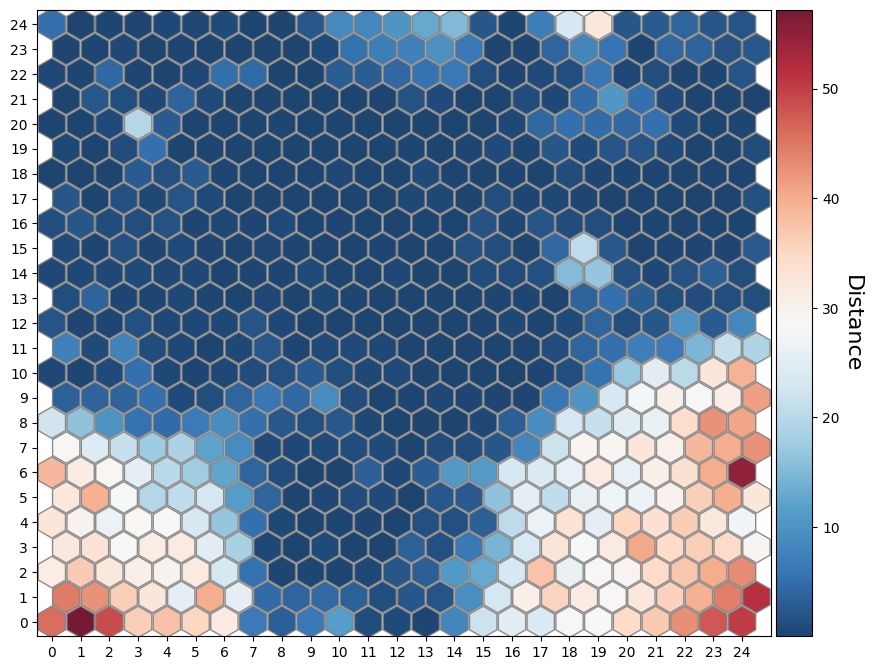

In [44]:
s_cnts = np.zeros((25, 25))
for idx, mu in all_regions.groupby(["Neuron_x", "Neuron_y"])['hom_pct'].mean().to_frame().iterrows():
    s_cnts[idx[0], idx[1]] = mu
ns_cnts = s_cnts / 100

norm = colors.Normalize(vmin=s_cnts.min(), vmax=s_cnts.max())
p = laytr.make_hex_plot(som,
                       hue=s_cnts,
                       color_map=cm.RdBu_r,
                       color_norm=norm,
                       alpha=0.9)
plt.savefig("Homopolymer.pdf")

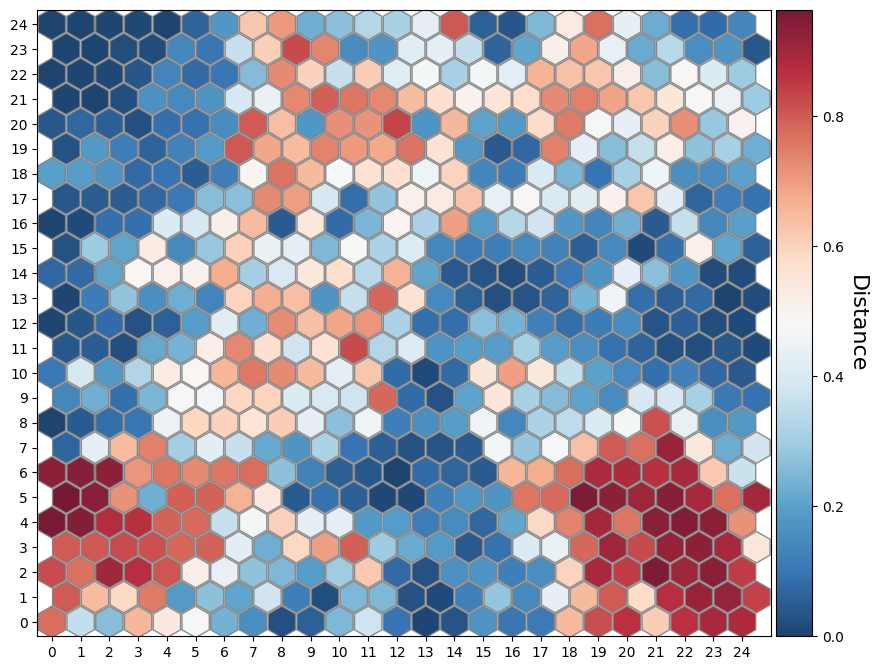

In [45]:
anno = pd.read_csv(bdir + "repeat_specs_GRCh38_without_mismatches.sorted.trimmed.at_least_9bp.bed.gz", 
                   sep='\t', header=None)[[0, 1, 2]].rename(columns={0:"Chromosome",
                                                                     1:"Start",
                                                                     2:"End"})
anno = pyranges.PyRanges(anno)
subset = loci.overlap(anno)

s_cnts = np.zeros((25, 25))
for _, (x, y) in subset.df[["Neuron_x", "Neuron_y"]].iterrows():
    s_cnts[x, y] += 1
ns_cnts = s_cnts / tot_cnts

rev = 1 - ns_cnts
norm = colors.Normalize(vmin=rev.min(), vmax=rev.max())
p = laytr.make_hex_plot(som,
                       hue=rev,
                       color_map=cm.RdBu_r,
                       color_norm=norm,
                       alpha=0.9)
plt.savefig("NovelRelativeToBroad.pdf")